# **Inicialização**

In [46]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
#@title **Bibliotecas**

from operator import itemgetter

# Importação do pandas
import pandas as pd

# Importação do numpy
import numpy as np

# Importa MatPlot
import matplotlib.pyplot as plt

import math

import numpy as np

import random

import os

from random import shuffle

from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.ref_dirs import get_reference_directions

In [2]:
#@title **Dados de consumo database Bear_education_Danna e Bear_education_Darrell**

dir = "./Genome_Separate_Buildings/"

# Listar todos os arquivos na pasta
all_files = os.listdir(dir)
csv_files = [f for f in all_files if f.endswith('.csv')]

# Embaralhar a lista de arquivos CSV
shuffle(csv_files)

# Função para extrair o nome do usuário do nome do arquivo
def extract_user_name(file_name):
    # Extrai o nome entre underscores (_nome_)
    parts = file_name.split('_')
    if len(parts) >= 2:  # Verifica se há pelo menos dois underscores
        return parts[-1].split('.')[0]  # Pega a última parte antes do .csv
    return None

# Número máximo de usuários que você quer processar
max_users = 10  # Altere este valor para o número desejado

defalt_users = [
    {
        "Bear_education_": ["Darrell", "Gavin", "Iris", "Clint"]},
    {
        "Wolf_education_": ['Miguel', 'Vivian']},
    {
        "Wolf_office_": ['Emanuel']},
    {
        "Swan_unknown_": ['Bette', 'Isaiah', 'Reyna']}]

# Lista para armazenar os arquivos e os nomes dos usuários
arquivos = []
users = []

for files in defalt_users:
    for chave, users_names in files.items():
        arquivos += [(dir + chave+user+'.csv',user) for user in users_names]
        users += users_names

# Processar os arquivos
for file_name in csv_files:
    if len(users) >= max_users:
        break
    user_name = extract_user_name(file_name)
    if user_name:
        if user_name not in users:
            users.append(user_name)
            arquivos.append((dir + file_name, user_name))

# Dicionário para armazenar os dados dos consumidores
consumidor = {}

# Processar cada arquivo
for arquivo, cosumidor_name in arquivos:
    c = pd.read_csv(arquivo, delimiter=",").iloc[:, 1:]
    c = c.set_axis(list(c.iloc[:, 0]), axis=0).iloc[:, 1:]

    # Converter o índice para o tipo de dados 'datetime'
    c.index = pd.to_datetime(c.index)

    # Criar uma série com intervalo de horas para o período desejado
    periodo_completo = pd.date_range(start="2016-01-01 00:00:00", end="2017-12-31 23:00:00", freq='h')

    # Reamostrar o DataFrame para o novo período completo e aplicar a interpolação linear
    consumidor[cosumidor_name] = c.reindex(periodo_completo).interpolate(method='linear')

    print((cosumidor_name, consumidor[cosumidor_name].mean().iloc[0]), end=" ")

('Darrell', np.float64(39.28045494186047)) ('Gavin', np.float64(89.97713692145462)) ('Iris', np.float64(45.50607914956681)) ('Clint', np.float64(56.78198553921568)) ('Miguel', np.float64(35.105273811559506)) ('Vivian', np.float64(71.32430717054264)) ('Emanuel', np.float64(15.086507424190607)) ('Bette', np.float64(37.11234284893739)) ('Isaiah', np.float64(119.07638425043079)) ('Reyna', np.float64(87.3732023555096)) 

In [3]:
consumidor[users[0]]

,meter_reading
2016-01-01 00:00:00,21.0625
2016-01-01 01:00:00,20.4882
2016-01-01 02:00:00,20.3655
2016-01-01 03:00:00,20.2887
2016-01-01 04:00:00,19.9610
...,...
2017-12-31 19:00:00,17.6102
2017-12-31 20:00:00,17.6022
2017-12-31 21:00:00,17.5627
2017-12-31 22:00:00,17.6767


In [4]:
def label_figure(users, title, ylabel, xlabel, fontsize, rotation):
    # plt.title(title,  fontsize = fontsize)
    plt.ylabel(ylabel,  fontsize = fontsize)
    plt.xlabel(xlabel,  fontsize = fontsize)
    plt.xticks(fontsize=fontsize-3, rotation=rotation)
    plt.yticks(fontsize=fontsize-3)
    
    if len(users) > 0:
        plt.legend(users, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=5, fontsize=fontsize-3)
    
    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


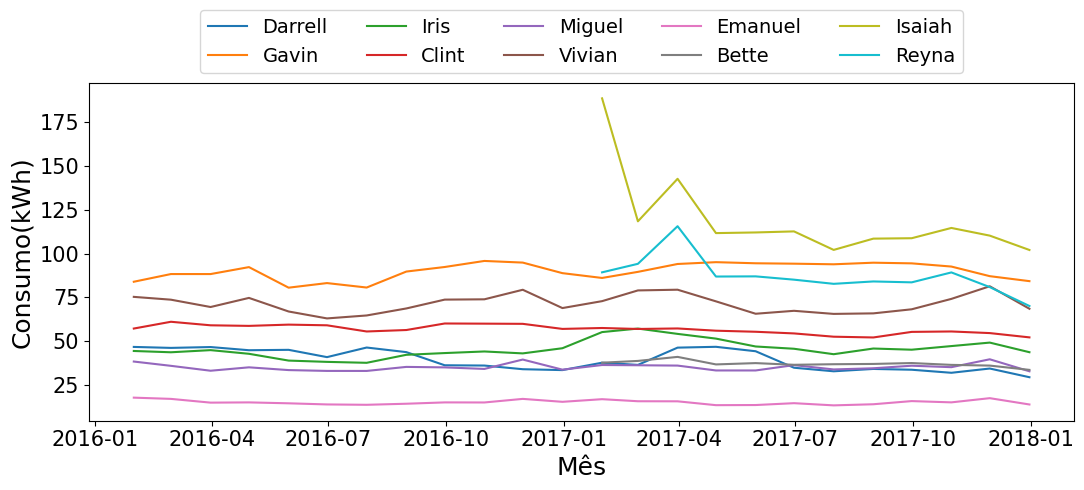

In [5]:
#@title **Comsumo de 2016 à 2017**
font = 18
plt.figure(figsize=(11,5))
for user in users[:10]:
    plt.plot(consumidor[user].resample('ME').mean())

plt.ylabel('Consumo(kWh)',  fontsize = font)
plt.xlabel('Mês',  fontsize = font)
plt.xticks(fontsize=font-3)
plt.yticks(fontsize=font-3)

if len(users) > 0:
    plt.legend(users, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=5, fontsize=font-4)

plt.tight_layout()

os.makedirs("./figuras/consumo", exist_ok=True)
plt.savefig(f"./figuras/consumo/{max_users}-consumo.eps", format='eps')
plt.show()

In [7]:
#@title **Acesso aos Arquivos Meterologicos**
# https://mapas.inmet.gov.br/

Met = {}
anos = ['2016', '2017']
for ano in anos:
    arquivo = f"./smart-grid/dados/{ano}/INMET_SE_ES_A612_VITORIA_01-01-{ano}_A_31-12-{ano}.csv"
    Met[ano] = pd.read_csv(os.path.abspath(arquivo), delimiter=";")
    
DadosMet = pd.concat([Met[ano] for ano in anos])

colunas_selecionadas = ["Data","Hora (UTC)","Temp. Ins. (C)","Vel. Vento (m/s)","Radiacao (KJ/m²)", "Chuva (mm)"]
DadosMet = DadosMet[colunas_selecionadas]
DadosMet.columns=['Data','Hora','temperatura', 'vento', 'radiacao', 'chuva']

# Acerto Hora
try:
    DadosMet['Hora'] /= 100
    DadosMet['Hora'] = DadosMet['Hora'].astype(str).str.replace(".0", ":00")
    DadosMet['Data'] = pd.to_datetime(DadosMet['Data'] + ' ' + DadosMet['Hora'], format='%d/%m/%Y %H:%M')
except:
    DadosMet['Data'] = pd.to_datetime(DadosMet['Data'] + ' ' + DadosMet['Hora'])
# DadosMet = DadosMet.set_axis(list(DadosMet['Data']), axis=0)

# Definir a coluna 'Data' como índice
DadosMet = DadosMet.set_index('Data')

# Converter vírgulas para pontos e transformar em numérico
DadosMet['radiacao'] = pd.to_numeric(DadosMet['radiacao'].str.replace(",", "."), errors='coerce')
DadosMet['temperatura'] = pd.to_numeric(DadosMet['temperatura'].str.replace(",", "."), errors='coerce')
DadosMet['vento'] = pd.to_numeric(DadosMet['vento'].str.replace(",", "."), errors='coerce')
DadosMet['chuva'] = pd.to_numeric(DadosMet['chuva'].str.replace(",", "."), errors='coerce')

DadosMet['radiacao'] = DadosMet['radiacao'].fillna(0.0)

# Calcular irradiância solar (converter kJ/m² para W/m²)
DadosMet['irradiancia'] = round(DadosMet['radiacao'] * 0.2777777778, 1)

# Remover colunas desnecessárias
DadosMet = DadosMet.drop(columns=['Hora', 'radiacao'])

# Interpolar valores faltantes
DadosMet = DadosMet.interpolate(method='time').bfill()

# Garantir que o índice seja datetime
DadosMet.index = pd.to_datetime(DadosMet.index)

DadosMet

,temperatura,vento,chuva,irradiancia
Data,,,,
2016-01-01 00:00:00,26.9,3.0,0.0,0.0
2016-01-01 01:00:00,26.8,2.9,0.0,0.0
2016-01-01 02:00:00,26.7,2.2,0.0,0.0
2016-01-01 03:00:00,26.7,2.5,0.0,0.0
2016-01-01 04:00:00,26.4,1.4,0.0,0.0
...,...,...,...,...
2017-12-31 19:00:00,30.5,3.9,0.0,507.6
2017-12-31 20:00:00,28.4,3.8,0.0,222.6
2017-12-31 21:00:00,27.6,3.4,0.0,72.5


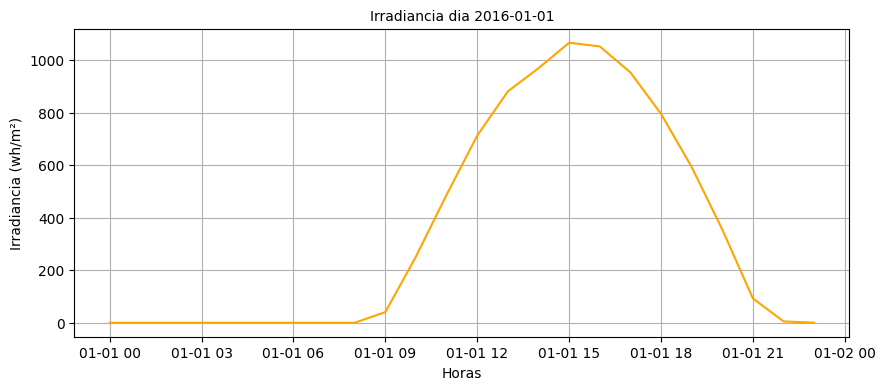

In [8]:
#@title **Gráfico irradiancia dia 1 do primeiro ano**
plt.figure(figsize=(10,4))

plt.grid(True)
plt.title(f'Irradiancia dia {anos[0]}-01-01',  fontsize = 10)
plt.ylabel('Irradiancia (wh/m²)',  fontsize = 10)
plt.xlabel('Horas',  fontsize = 10)

plt.plot(DadosMet['irradiancia'][:24], color='orange')
plt.show()

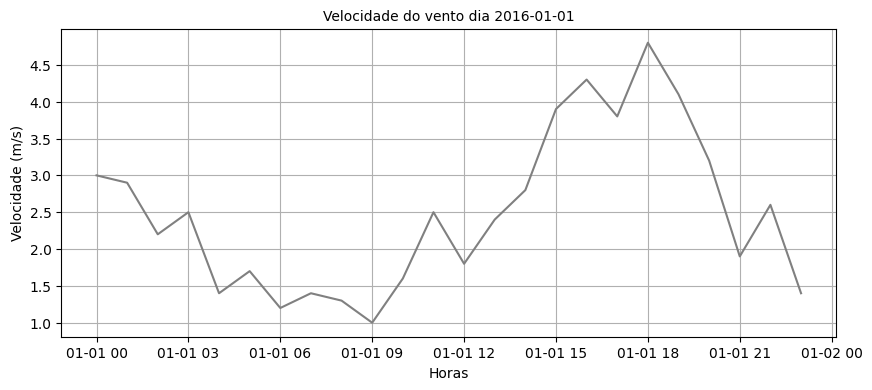

In [9]:
#@title **Gráfico Vento dia 1 do primeiro ano**
plt.figure(figsize=(10,4))

plt.grid(True)
plt.title(f'Velocidade do vento dia {anos[0]}-01-01',  fontsize = 10)
plt.ylabel('Velocidade (m/s)',  fontsize = 10)
plt.xlabel('Horas',  fontsize = 10)

plt.plot(DadosMet['vento'][:24], color='grey')
plt.show()

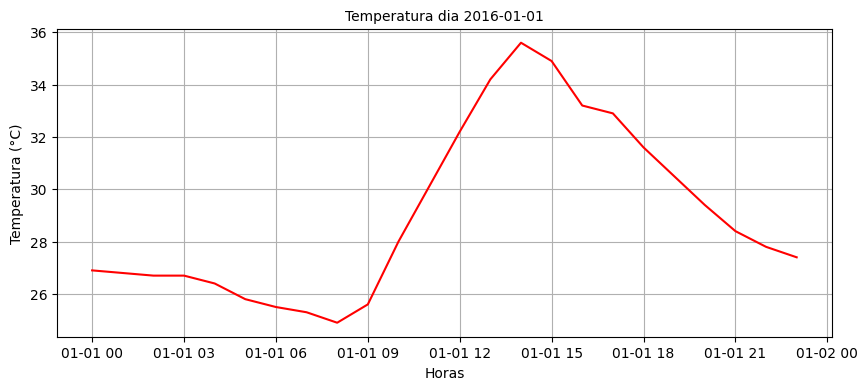

In [10]:
plt.figure(figsize=(10,4))

plt.grid(True)
plt.title(f'Temperatura dia {anos[0]}-01-01',  fontsize = 10)
plt.ylabel('Temperatura (°C)',  fontsize = 10)
plt.xlabel('Horas',  fontsize = 10)

plt.plot(DadosMet['temperatura'][:24], color='red')
plt.show()

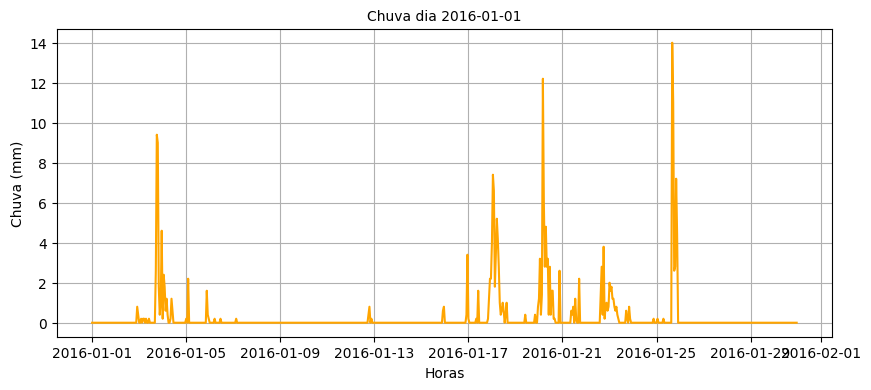

In [11]:
#@title **Gráfico chuva mês 1 do primeiro ano**
plt.figure(figsize=(10,4))

plt.grid(True)
plt.title(f'Chuva dia {anos[0]}-01-01',  fontsize = 10)
plt.ylabel('Chuva (mm)',  fontsize = 10)
plt.xlabel('Horas',  fontsize = 10)

plt.plot(DadosMet['chuva'][:24*30], color='orange')
plt.show()

In [ ]:
#@title **Informações da placa**
# https://www.neosolar.com.br/loja/painel-solar-fotovoltaico-280w-osda-oda280-30-p.html

#POTENCIA GERADA PELOS PV's DO MODELO ODA280-30-P 280W
Vmppt = 31.94   # é a tensão no ponto de máxima potência (V);
Imppt = 8.77    # é a corrente no ponto de máxima potência (A).
Voc = 38.33     # é a tensão de circuito aberto do módulo (V);
Isc = 9.41      # é a corrente de curto circuito da célula (A);
nc = 0.1899     # é a eficiência da placa
Not = 45        # é a temperatura nominal de operação da célula (oC);
Kv = -0.3       # é o coeficiente de tensão/temperatura (V/ oC);
Ki = 0.06       # é o coeficiente de corrente/temperatura (A/ oC);

# Constantes
RNOCT = 1000
ta = 0.9

power_placa = Voc*Isc   # é a potencia da Placa

In [ ]:
NPaineis = {}
ir_med = 4.5
horas_exposto = 6       # é a quantidade de horas de exposição da placa
for user in users:
    consumo_medio = (consumidor[user]*1000).mean().iloc[0] # media Wh
    NPaineis[user] =  math.ceil((consumo_medio/(power_placa*ir_med*0.75*horas_exposto)))
print(f"Placas - {NPaineis}")

Placas - {'Darrell': 6, 'Gavin': 13, 'Iris': 7, 'Clint': 8, 'Miguel': 5, 'Vivian': 10, 'Emanuel': 3, 'Bette': 6, 'Isaiah': 17, 'Reyna': 12}


In [ ]:
#@title **Painel solar**
PotPVM = {}
for user in users:
    PotPVM[user] = []
    for i in range(len(DadosMet)):
        r   = DadosMet['irradiancia'].iloc[i]
        Ta  = DadosMet['temperatura'].iloc[i]
        Vw  = DadosMet['vento'].iloc[i]
        Tc  = Ta + ((r/RNOCT) * (9.5/(5.7+3.8*Vw)) * (Not-20) * (1 - (nc/ta)))   # Ta + r*(Not-20)/0.8
        I   = r * (Isc + Ki *(Tc-25))
        V   = Voc - Kv *(Tc-25)
        FF  = (Vmppt * Imppt)/(Voc * Isc)
        PotPVM[user].append(NPaineis[user] * FF * V * I)

    PotPVM[user] = pd.DataFrame(PotPVM[user], index=DadosMet.index, columns=["Power (kW)"])/10000

PotPVM[users[0]].iloc[:24,:]

,Power (kW)
Data,
2016-01-01 00:00:00,0.000000
2016-01-01 01:00:00,0.000000
2016-01-01 02:00:00,0.000000
2016-01-01 03:00:00,0.000000
2016-01-01 04:00:00,0.000000
2016-01-01 05:00:00,0.000000
2016-01-01 06:00:00,0.000000
2016-01-01 07:00:00,0.000000
2016-01-01 08:00:00,0.000000


In [60]:
PotPVM[user].iloc[:24,:].index.strftime('%HH')

Index(['00H', '01H', '02H', '03H', '04H', '05H', '06H', '07H', '08H', '09H',
       '10H', '11H', '12H', '13H', '14H', '15H', '16H', '17H', '18H', '19H',
       '20H', '21H', '22H', '23H'],
      dtype='object', name='Data')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


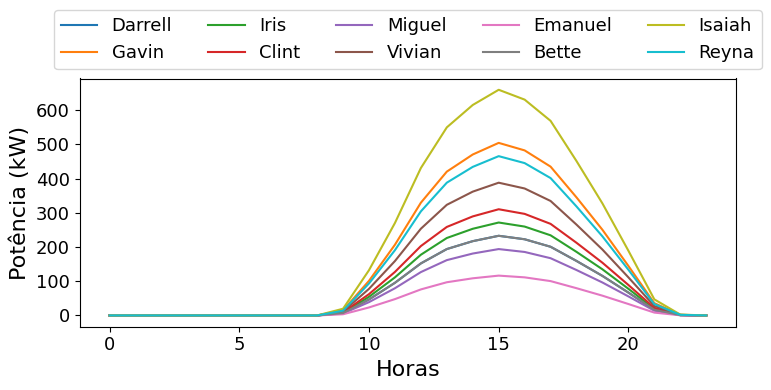

In [61]:
#@title **Geração no dia 1 do primeiro ano**
plt.figure(figsize=(8,4))

for user in users[:10]:
    plt.plot(PotPVM[user].iloc[:24,:].index.hour, PotPVM[user].iloc[:24,0].values)

label_figure(users, 'Geração Painel solar', 'Potência (kW)', 'Horas', 16, 0)

os.makedirs("./figuras/geracao", exist_ok=True)
plt.savefig(f"./figuras/geracao/{max_users}-geracao.eps", format='eps')
plt.show()

In [62]:
#@title **EnergBaterry**

from pandas import DataFrame


def energBaterry(l, g, max_battery):
  battery = 0
  bat   = l.copy()*0
  load  = l.copy()
  grid  = g.copy()
  
  
  for i, energ in enumerate(zip(load.iloc[:,0], grid.iloc[:,0])):
    geracao, consumo = energ
    if int(bat.iloc[i:i+1,:].index[0].strftime('%H')) == 1:
      battery = 0
    elif(i):
      battery    = bat.iloc[i-1,0]

    res   = geracao - consumo

    if(res < 0):
      consumo = (-1) * res
      res = 0
      consumo = consumo - battery
      if(consumo < 0):
        battery = (-1) * consumo
        consumo = 0
      else:
        battery = 0
    elif (battery < max_battery):
      consumo = 0
      if (res <= (max_battery-battery)):
        battery = battery + res
        res     = 0
      else:
        res     = res - (max_battery - battery)
        battery = max_battery
    else:
      consumo = 0

    grid.iloc[i,0]  = consumo
    load.iloc[i,0]  = res
    bat.iloc[i,0]   = battery
    
  df = round(pd.concat([grid, load, bat], axis=1), 1) # type: ignore
  df.columns = ['grid', 'load', 'battery']
  return df

In [63]:
print(f"geração len - {len(PotPVM[users[0]])}, consumo len - {len(consumidor[users[0]])}")

geração len - 17544, consumo len - 17544


In [64]:
# Bateria Megapack Tesla 1.9MW
max_battery = 1900 # kW
qtd_battery = 1

consumidor_baterry = {}
for chave, consumo in consumidor.items():
    consumidor_baterry[chave] = energBaterry(PotPVM[chave], consumo, max_battery * qtd_battery)
consumidor_baterry[users[0]].iloc[:24,:]

,grid,load,battery
2016-01-01 00:00:00,21.1,0.0,0.0
2016-01-01 01:00:00,20.5,0.0,0.0
2016-01-01 02:00:00,20.4,0.0,0.0
2016-01-01 03:00:00,20.3,0.0,0.0
2016-01-01 04:00:00,20.0,0.0,0.0
2016-01-01 05:00:00,21.1,0.0,0.0
2016-01-01 06:00:00,21.6,0.0,0.0
2016-01-01 07:00:00,21.4,0.0,0.0
2016-01-01 08:00:00,21.9,0.0,0.0
2016-01-01 09:00:00,14.6,0.0,0.0


In [65]:
## Se valores ficarem None, datas diferentes entre geração e consumo
sum([consumidor_baterry[user].isna().sum().sum() for user in users])

np.int64(26519)

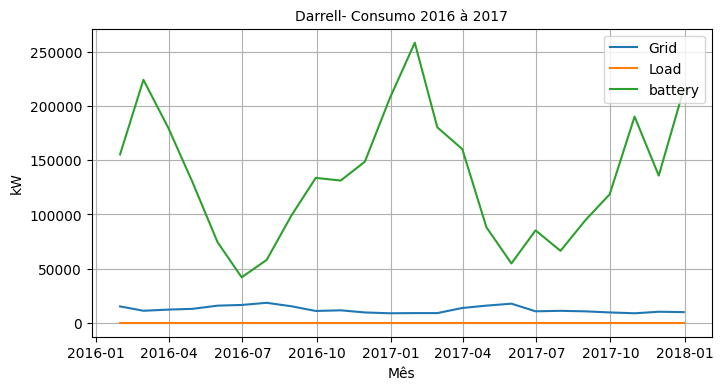

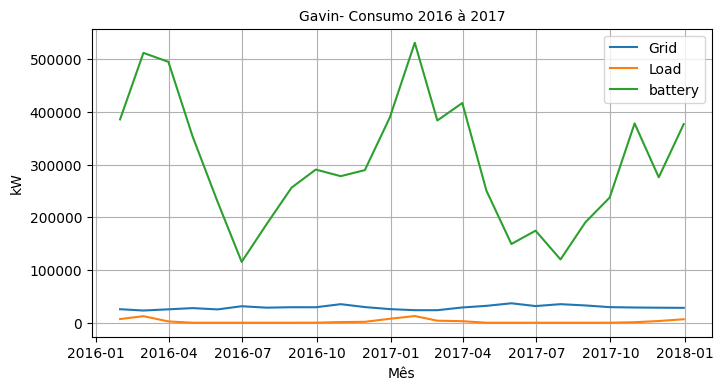

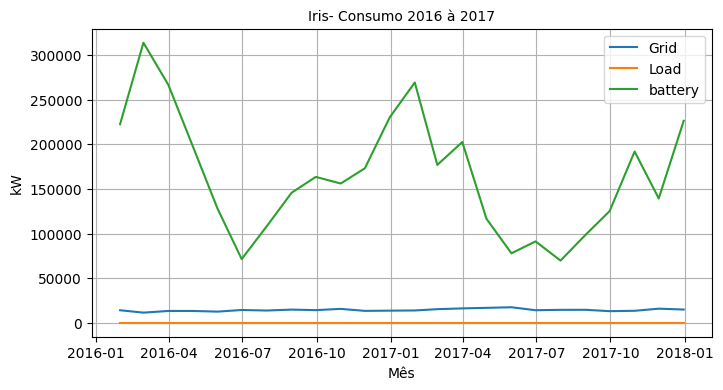

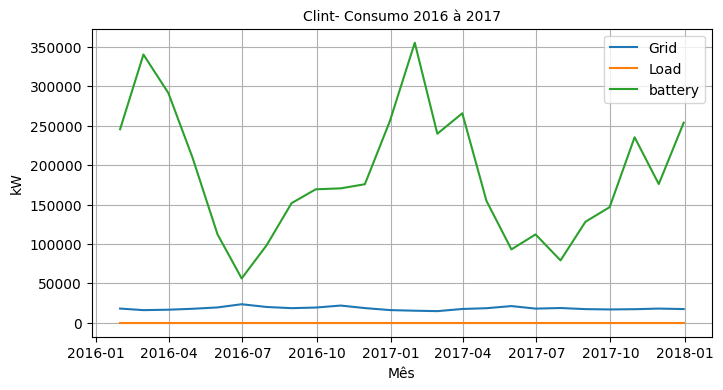

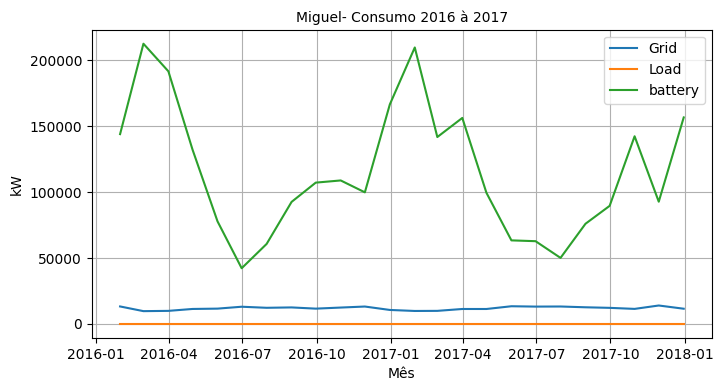

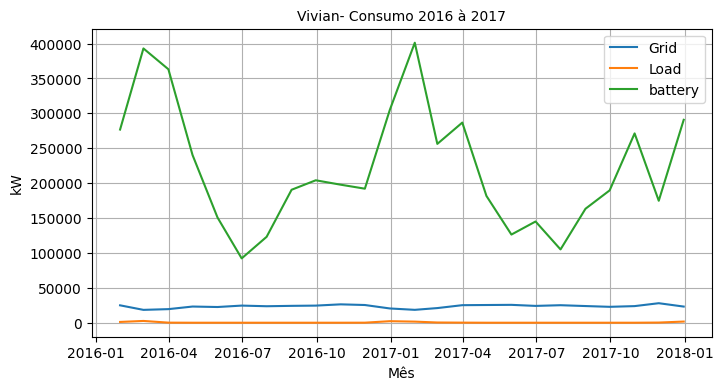

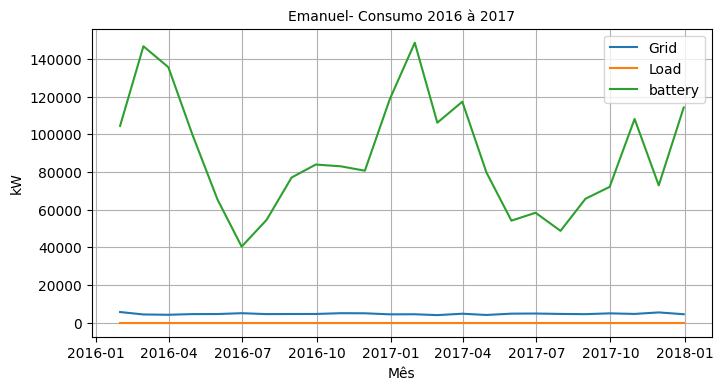

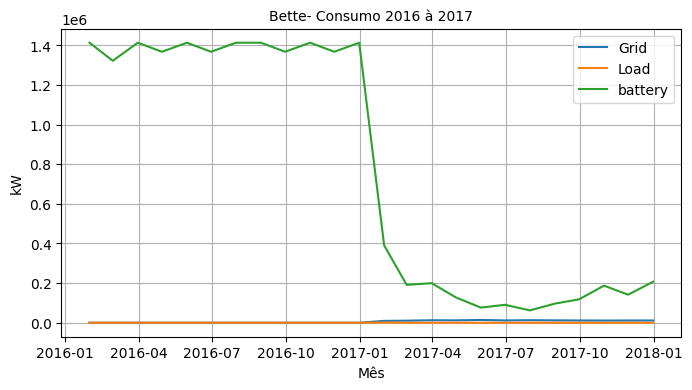

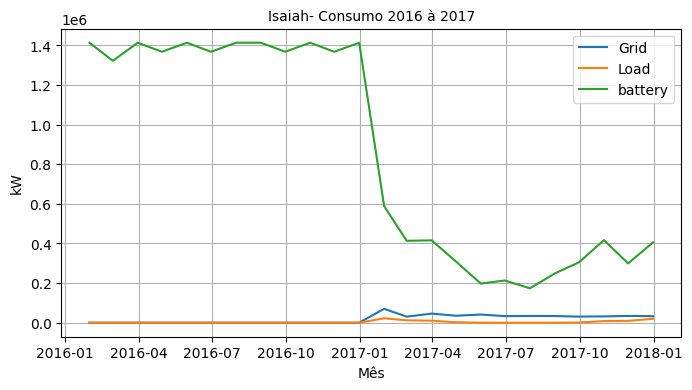

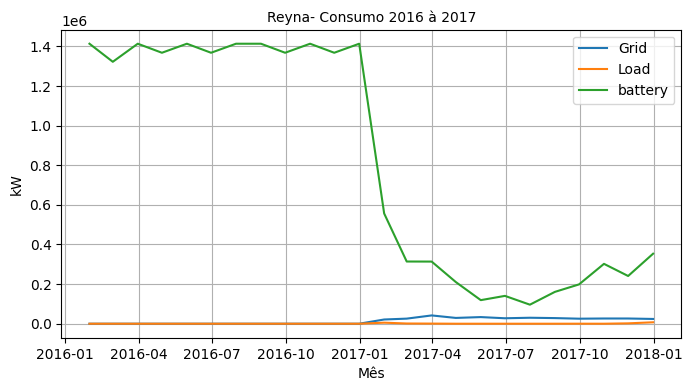

In [66]:
for user in users[:10]: 
    plt.figure(figsize=(8,4))
    plt.grid(True)
    plt.title(user+f'- Consumo {anos[0]} à {anos[1]}',  fontsize = 10)
    plt.ylabel('kW',  fontsize = 10)
    plt.xlabel('Mês',  fontsize = 10)

    plt.plot(consumidor_baterry[user].resample('ME').sum().resample('ME').mean())
    plt.legend(['Grid', 'Load', 'battery'])
    plt.show()

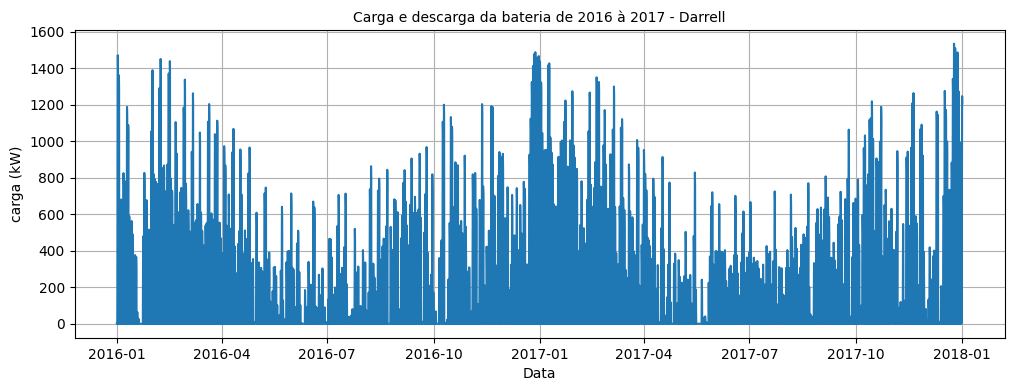

In [67]:
#@title **Carga e descarga da bateria nos primeiros 4 mês de Janeiro de 2017 - Danna**
plt.figure(figsize=(12,4))

plt.grid(True)
plt.title(f'Carga e descarga da bateria de {anos[0]} à {anos[1]} - '+users[0],  fontsize = 10)
plt.ylabel('carga (kW)',  fontsize = 10)
plt.xlabel('Data',  fontsize = 10)

plt.plot(consumidor_baterry[users[0]]['battery'])#.iloc[:24*30*4,2:3])

plt.show()

In [68]:
consumo_ano = {}
for user in users:
    consumo_ano[user] = consumidor_baterry[user].resample('ME').sum()
    # consumo_ano[user] = consumidor_baterry[user].copy()
consumo_ano[users[0]]

,grid,load,battery
2016-01-31,15050.3,0.0,155429.8
2016-02-29,11055.0,0.0,224331.5
2016-03-31,12119.1,0.0,179777.2
2016-04-30,12817.4,0.0,129673.0
2016-05-31,15759.6,0.0,74461.6
2016-06-30,16403.2,0.0,41964.5
2016-07-31,18397.3,0.0,57981.9
2016-08-31,15170.7,0.0,99263.1
2016-09-30,10857.3,0.0,133749.6
2016-10-31,11459.7,0.0,131307.1


In [69]:
# Criar um dicionário vazio para armazenar os DataFrames de crédito
credit = {user: pd.DataFrame(0.0, index=df.index, columns=['grid', 'load']) for user, df in consumo_ano.items()}

# for user, df in consumo_ano.items():
#     for index, row in df.iterrows():
#         if row['load'] > row['grid']:
#             credit[user].at[index, 'load'] = row['load'] - row['grid']
#             credit[user].at[index, 'grid'] = 0
#         else:
#             credit[user].at[index, 'grid'] = row['grid'] - row['load']
#             credit[user].at[index, 'load'] = 0

# Exibir o DataFrame de crédito para o primeiro usuário

# Remover   
for user in users:
    credit[user] = consumo_ano[user]#.iloc[:-3,:]
display(credit[users[0]])


,grid,load,battery
2016-01-31,15050.3,0.0,155429.8
2016-02-29,11055.0,0.0,224331.5
2016-03-31,12119.1,0.0,179777.2
2016-04-30,12817.4,0.0,129673.0
2016-05-31,15759.6,0.0,74461.6
2016-06-30,16403.2,0.0,41964.5
2016-07-31,18397.3,0.0,57981.9
2016-08-31,15170.7,0.0,99263.1
2016-09-30,10857.3,0.0,133749.6
2016-10-31,11459.7,0.0,131307.1


In [70]:
tarifa_unitaria = pd.DataFrame(index=pd.date_range(start='2016-01-31 00:00:00', end='2017-12-31 23:00:00', freq='1H'))
tarifa_unitaria = tarifa_unitaria.reindex(consumidor[users[0]].index)
tarifa_unitaria['tarifa_unitaria'] = 0.0

# SUBGRUPO A4 (TUSD + TE) Modalidade Verde 
tarifa_2015 = {'ponta': 0.68877 + 0.39493, 'fora ponta': 0.07451 + 0.24742} # RESOLUÇÃO HOMOLOGATÓRIA No 1.927, DE 4 DE AGOSTO DE 2015
tarifa_2016 = {'ponta': 0.51204 + 0.38631, 'fora ponta': 0.11703 + 0.24937} # RESOLUÇÃO HOMOLOGATÓRIA No 2.182, DE 29 DE NOVEMBRO DE 2016
tarifa_2017 = {'ponta': 1.24856 + 0.35173, 'fora ponta': 0.06780 + 0.22941} # RESOLUÇÃO HOMOLOGATÓRIA No 2.207, DE 14 DE MARÇO DE 2017

for idx in tarifa_unitaria.index:
    if idx.year == 2015:
        tarifa = tarifa_2015
    elif idx.year == 2016:
        tarifa = tarifa_2016
    else:
        tarifa = tarifa_2017

    if 18 <= idx.hour <= 21:
        tarifa_unitaria.loc[idx, 'tarifa_unitaria'] = tarifa['ponta']
    else:
        tarifa_unitaria.loc[idx, 'tarifa_unitaria'] = tarifa['fora ponta']

display(tarifa_unitaria)

C:\Users\arthu\AppData\Local\Temp\ipykernel_22200\3714412325.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tarifa_unitaria = pd.DataFrame(index=pd.date_range(start='2016-01-31 00:00:00', end='2017-12-31 23:00:00', freq='1H'))


,tarifa_unitaria
2016-01-01 00:00:00,0.36640
2016-01-01 01:00:00,0.36640
2016-01-01 02:00:00,0.36640
2016-01-01 03:00:00,0.36640
2016-01-01 04:00:00,0.36640
...,...
2017-12-31 19:00:00,1.60029
2017-12-31 20:00:00,1.60029
2017-12-31 21:00:00,1.60029
2017-12-31 22:00:00,0.29721


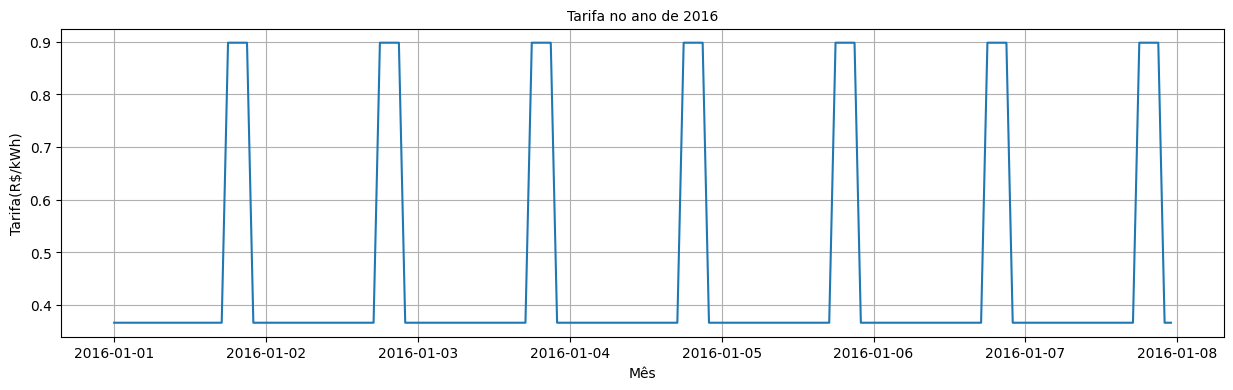

In [72]:
#@title **Tarifa no ano de 2016**
plt.figure(figsize=(15,4))

plt.grid(True)
plt.title('Tarifa no ano de 2016',  fontsize = 10)
plt.ylabel('Tarifa(R$/kWh)',  fontsize = 10)
plt.xlabel('Mês',  fontsize = 10)

plt.plot(tarifa_unitaria.iloc[:168,:])

plt.show()

In [76]:
#@title **Custo anual de eletricidade**
c_fit = 0
c_tarifa_unitaria = tarifa_unitaria.iloc[:,0]
Ce = lambda e_b, user: (energBaterry(PotPVM[user], consumidor[user], e_b)['grid'] * c_tarifa_unitaria).sum()
round(Ce(572241, users[0]),2)

np.float64(110512.45)

In [77]:
#@title **Custo anual relacionado à bateria**
SOH         = 0.8
rep         = 0.6
c_ic        = 0.684372
e_b         = 3.9 * 10**6 # capacidade da bateria # Otimizar

c_bat       = lambda e_b: (((1-SOH)/(1-rep))*c_ic*e_b)

round(c_bat(e_b),2)

1334525.4

In [78]:
#@title **Custo anual total do sistema solar com bateria**
Cop = lambda e_b, user: c_bat(e_b) + Ce(e_b, user)
round(Cop(2000, users[0]),2)

np.float64(111196.82)

In [79]:
C_pv = lambda user: ((consumidor[user].iloc[:,0] - PotPVM[user].iloc[:,0]) * c_tarifa_unitaria).clip(lower=0).sum()
C_pv(users[0])

np.float64(158951.07632401126)

In [80]:
#@title **C_sav**
C_sav = lambda e_b, user: C_pv(user) - Cop(e_b, user)
round(C_sav(2000, users[0]), 2)

np.float64(47754.26)

In [81]:
#@title **Retorno de investimento**
roi = lambda e_b, user: (C_sav(e_b, user)/c_bat(e_b))*100
round(roi(348528.36539327, users[0]),2)

np.float64(-59.38)

In [ ]:
# Função para realizar a otimização com base em uma seed específica
def run_optimization(problem, algorithm, seed, verbose=False):
    # Executar a otimização com a seed específica
    result = minimize(problem, algorithm, seed=seed, termination=('n_gen', 1), verbose=verbose)

    # Armazenar o resultado e a seed diretamente na lista
    results_list.append((result, seed))

# Definir o problema de otimização
n_var = 1
max_baterry = 3.9*10**6
objs = [c_bat, lambda e_b: [Ce(e_b, users[0])]]
problem = FunctionalProblem(n_var, objs, xl=np.full(n_var, 0), xu=np.full(n_var, max_baterry))

# Configurar o algoritmo NSGA-III
num_ref_dirs = 100
ref_dirs_custom = np.linspace(0, max_baterry, num_ref_dirs)
ref_dirs_custom = np.column_stack((ref_dirs_custom, np.flip(ref_dirs_custom)))
algorithm = NSGA3(pop_size=100, ref_dirs=ref_dirs_custom)
    
# Lista de seeds que serão utilizadas para a otimização
num_seeds = 5
seeds = np.random.randint(1, 1000, size=num_seeds).tolist()

# Criar uma lista para armazenar os resultados e as seeds
results_list = []

# # Criar threads para executar a otimização para cada seed
# threads = [threading.Thread(target=run_optimization, args=(problem, algorithm, seed,)) for seed in seeds[:len(seeds)-1]]
# threads.append(threading.Thread(target=run_optimization, args=(problem, algorithm, seeds[len(seeds)-1], True,)))

result = minimize(problem, algorithm, seed=980, termination=('n_gen', 10), verbose=True)

# # Iniciar as threads
# for thread in threads:
#     thread.start()

# # Aguardar todas as threads serem concluídas
# for thread in threads:
#     thread.join()
    
# result_max = results_list[0]
# for result in results_list:
#     len_population = len(result[0].X)
#     if (len(result_max[0].X)<=len_population):
#         result = result

# # Acessar os resultados
# result = result_max[0]

final_population = result.X
final_objectives = result.F

# Imprimir os resultados
lista = []
for individual, objectives in zip(final_population, final_objectives):
    dist = np.linalg.norm([0, 0] - objectives)
    print("Individual: ", individual)
    print("Objectives: ", objectives)
    print("Distancia:  ", [dist])
    print("------------------------")

    lista.append((individual, objectives, dist))

print(min(lista, key=lambda x: x[2]))

scatter_plot = Scatter().add(result.F).show()

scatter_plot.save("scatter_plot.png")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  8.104843E+03 |         ideal
     3 |      300 |      1 |  8.105028E+03 |         ideal
     4 |      400 |      1 |  0.000000E+00 |             f
     5 |      500 |      2 |  1.0000000000 |         ideal
     6 |      600 |      4 |  0.1010688921 |         ideal
     7 |      700 |      6 |  0.0361499506 |         ideal
     8 |      800 |     10 |  0.1137799540 |         ideal


In [ ]:
for result in results_list:
    print(len(result[0].X), result) 

In [ ]:
# 49 [298]
# 52 (<pymoo.core.result.Result object at 0x000001D55FC04AD0>, 980)
print(len(result.X))

26


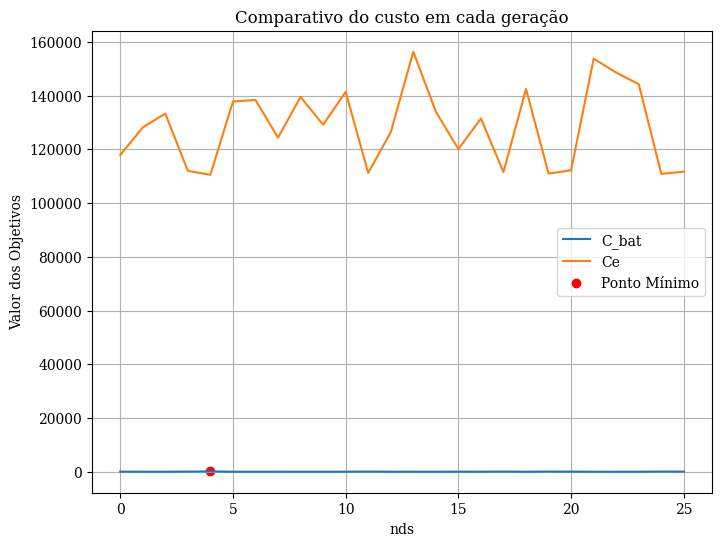

In [ ]:
# Criação do gráfico
plt.figure(figsize=(8, 6))

# Transposta do array final_objectives para facilitar o plotting
final_objectives_transpose = final_objectives.T

# Plotar cada objetivo em uma reta usando broadcasting do NumPy
plt.plot(final_objectives_transpose[0], label="C_bat")
plt.plot(final_objectives_transpose[1], label="Ce")

# Encontrar o ponto mínimo na lista de tuplas (individual, objectives, dist)
min_dist_point = min(lista, key=lambda x: x[2])

# Extrair o índice do ponto mínimo na lista
min_dist_index = lista.index(min_dist_point)

# Marcando o ponto mínimo no gráfico
plt.scatter(min_dist_index, min_dist_point[1][0], color='red', label='Ponto Mínimo')

plt.xlabel("nds")
plt.ylabel("Valor dos Objetivos")
plt.legend()
plt.grid(True)
plt.title("Comparativo do custo em cada geração")
plt.show()

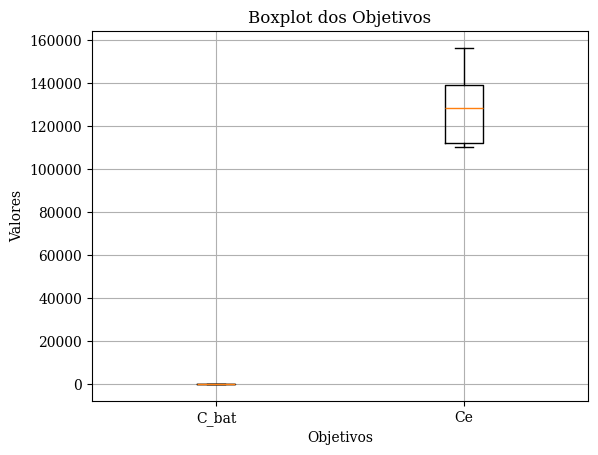

In [ ]:
import matplotlib.pyplot as plt

# Rótulos dos objetivos
labels = ['C_bat', 'Ce']

# Criar o boxplot
plt.boxplot(final_objectives, labels=labels)

# Configurar o gráfico
plt.title('Boxplot dos Objetivos')
plt.xlabel('Objetivos')
plt.ylabel('Valores')
plt.grid(True)

# Exibir o gráfico
plt.show()

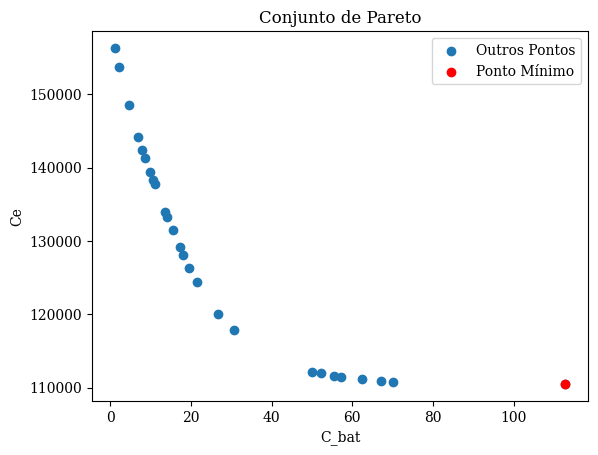

In [ ]:
# Função para verificar se um ponto é dominado por outro ponto
def is_dominated(point, other_points):
    return np.any(np.all(point >= other_points, axis=1))

# Encontrar o conjunto de Pareto
pareto_front = []
for i, point in enumerate(final_objectives):
    if not is_dominated(point, np.delete(final_objectives, i, axis=0)):
        pareto_front.append(point)

pareto_front = np.array(pareto_front)

# Encontrar o ponto mínimo na lista de tuplas (individual, objectives, dist)
min_dist_point = min(lista, key=lambda x: x[2])

# Extrair o índice do ponto mínimo na lista
min_dist_index = lista.index(min_dist_point)

# Plotar o gráfico de dispersão
plt.scatter(final_objectives[:, 0], final_objectives[:, 1], label="Outros Pontos")
plt.scatter(final_objectives[min_dist_index, 0], final_objectives[min_dist_index, 1], color='red', label="Ponto Mínimo")

# Definir os rótulos dos eixos
plt.xlabel("C_bat")
plt.ylabel("Ce")

# Definir o título do gráfico
plt.title("Conjunto de Pareto")

# Exibir a legenda
plt.legend()

# Exibir o gráfico
plt.show()

In [ ]:
b = min(lista, key=lambda x: x[2])[0][0]
b

np.float64(329.6860534844168)

In [ ]:
roi(min(lista, key=lambda x: x[2])[0][0])

TypeError: <lambda>() missing 1 required positional argument: 'user'

In [ ]:
C_pv

In [ ]:
Cop(b)